<a href="https://colab.research.google.com/github/nicolassalomon96/procesamiento_imagenes_UNS/blob/main/TP5/Transformada_de_Fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP5 - Transformada de Fourier y procesamiento espectral

Presentado por: Nicolás Salomón - email: nicolassalomon96@gmail.com

Aclaración: Dado que los widgets no se reproducen al ver el Notebook desde Github, es necesario ver el Notebook a través del link a Google Colaboratory

El objetivo de este TP es implementar un aplicativo que permita la generación de la Transformada de Fourier (TF) directa e Inversa de Imágenes, este debe permitir:

* Cargar una imagen
* Generar la TF directa de la imagen y ver su espectro
* A partir del espectro generado mediante la TF inversa obtener la imagen
* Debe permitir guardar el espectro de amplitud de una imagen en un bitmap
* Debe permitir cargar el espectro de imagen a partir de un bitmap.

Para esto se deben hacer pruebas con diferentes figuras geométricas (Cuadrados, rectángulos, círculos, elipses, rombos, dos o más objetos, etc.) (mostrar los espectros de mínimo 5 figuras diferentes).

Adicionalmente con una imagen de su elección guardar el espectro de amplitud de la imagen en un bitmap, luego editarlo con un editor gráfico (por ejemplo, Paint), cargarlo al aplicativo y finalmente aplicar la transformada inversa (preservando la fase) para ver los efectos.

Nota: se sugiere usar los widgets tipo botón para ejecutar las operaciones mencionadas y que el aplicativo interactivo tengas todas las funciones en el mismo entorno.

## 1. Librerias necesarias

In [ ]:
import os
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

## 2. Montamos nuestro Drive

In [ ]:
#Montamos nuestro Google Drive para tener acceso a las imágenes a leer
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Funciones necesarias

In [ ]:
#Variables globales empleadas en más de una función (para modificar los datos de la fft y mejorar su visualización (llevar los valores de 0 a 255, realizando una interpolación lineal))
m = 1
b = 0

#Función para pasar de RGB a escala de grises
def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.299 * r + 0.587 * g + 0.114 * b
  return gray

#Función para descargar imagen
def get_image(path):
  image = io.imread(path)

  #Verifico si es RGB y la convierto en escala de grises
  if (len(image.shape) > 2):
    image = np.clip((io.imread(path))/255.,0.,1.)
    image = rgb2gray(image)

  return image.astype('float64')

#Función para guardar una imagen
def save_image(image,path):
  image = image.astype('uint8')
  io.imsave(path,image)

#Función para plotear una imagen
def plot_image(image,title,figsize=(10,10)):
  plt.figure(figsize=(8,10))
  plt.imshow(image, cmap='gray')
  plt.title(title)
  plt.show()

#Funcion para crear un botones de guardado
def save_buttons(mag_image,phase_image,path):

  mag_button = widgets.Button(description='SAVE MAGNITUDE')
  phase_button = widgets.Button(description='SAVE PHASE')
  out = widgets.Output()

  def mag_button_clicked(b):
     with out:
      #Que sucede al presionar el boton
      save_image(mag_image,os.path.join(path,'magnitud.bmp'))     
      print("Magnitud guardada como .bmp")

  mag_button.on_click(mag_button_clicked)

  def phase_button_clicked(b):
     with out:
      #Que sucede al presionar el boton
      save_image(phase_image,os.path.join(path,'fase.bmp'))      
      print("Fase guardada como .bmp")
      
  phase_button.on_click(phase_button_clicked)
  
  buttons = widgets.HBox([mag_button, phase_button])
  display(buttons,out) 

#Funcion para crear un botón de guardado
def save_button(image,full_path,title):

  my_button = widgets.Button(description=title)
  out = widgets.Output()

  def my_button_clicked(b):
     with out:
      #Que sucede al presionar el boton
      save_image(image,full_path)     
      print("Imagen guardada")
  
  my_button.on_click(my_button_clicked)
  display(my_button,out)


#Funcion para crear un botón de carga del bitmap de magnitud
def load_button(phase,path_ifft_save,title):

  my_text = widgets.Text(value='/content/magnitud.bmp',
                         description='Path to load:',
                         placeholder='Type something',
                         continuous_update=True,
                         disabled=False)

  my_button = widgets.Button(description=title)
  out = widgets.Output()
  
  def bind_input_to_output():
    path = my_text.value
    return path

  def on_button_clicked(b):
    with out:
      #Que sucede al presionar el boton
      out.clear_output()
      path = bind_input_to_output()
      mag_image = get_image(path)

      #Convierto la imagen a formato 'uint8' en caso de estar en otro formato
      #(para realizar la fft, la imagen debe estar en formato 'uint8')
      if (mag_image.max() < 1.0):
        mag_image = (np.clip(mag_image*255,0,255)).astype('uint8')

      #Transformada inversa de Fourier
      image_mod = make_ifft(mag_image, phase)
      print('\n')   
      plot_ifft(image_mod)
      print('\n')
      image_mod = np.abs(image_mod) 
      image_mod = (np.clip(image_mod*255,0,255)).astype('uint8')
 
      save_button(image_mod,path_ifft_save,'SAVE IFFT')

  my_button.on_click(on_button_clicked)

  all_widgets = widgets.HBox([my_text,my_button])
  display(all_widgets,out)
  
#Función para interpolar los datos a 0-255
def interpolation(arr):
  global m,b
  arr_mod = np.empty_like(arr)
  max = np.amax(arr)
  min = np.amin(arr)
  m = (255 - 0)/(max - min)
  b = 255 - (255/(max - min))*max
  for i in range(len(arr)):
    for j in range(len(arr[i])):
      arr_mod[i][j] = m * arr[i][j] + b
  return arr_mod

#Función para hacer el camino inverso a la interpolación
def inv_interpolation(arr):
  arr_mod_inv = np.empty_like(arr)
  for i in range(len(arr)):
    for j in range(len(arr[i])):
      arr_mod_inv[i][j] = (arr[i][j] - b)/m
  return arr_mod_inv

#Función para calcular la fft de la imagen
def make_fft(image):
  fft = np.fft.fftshift(np.fft.fft2(image))
  mag = 1 + np.abs(fft)
  phase = np.angle(fft)
  mag = (interpolation(np.log(mag)))
  return mag, phase

#Función para calcular la ifft de la imagen
def make_ifft(mag, phase):

  ifft_img = np.empty(mag.shape, dtype=complex)
  mag_inv = inv_interpolation(mag)
  mag_inv = np.exp(mag_inv) - 1

  ifft_img.real = mag_inv * np.cos(phase)
  ifft_img.imag = mag_inv * np.sin(phase)

  img_mod = np.fft.ifft2(np.fft.ifftshift(ifft_img))
  return img_mod

#Función para plotar la imagen original junto con la magnitud y phase de la fft
def plot_fft(image, mag, phase):
  fig, axs = plt.subplots(1,3,figsize=(30,8))
  
  plt.subplot(1,3,1)
  plt.imshow(image, cmap='gray')
  plt.title("Imagen")

  plt.subplot(1,3,2)
  plt.imshow(mag, cmap='gray')
  plt.title("FFT: Magnitud")
  
  plt.subplot(1,3,3)
  plt.imshow(phase, cmap='gray')
  plt.title("FFT: Fase")

  plt.show()

def plot_ifft(ifft_image):
  image_mod = np.abs(ifft_image)
  image_mod = (np.clip(image_mod*255,0,255)).astype('uint8')
  plt.figure(figsize=(8,10))
  plt.imshow(image_mod, cmap='gray')
  plt.title("Transformada inversa de Fourier")
  plt.show()


## 4. Aplicativo para cargar y generar FFT e IFFT de una imagen

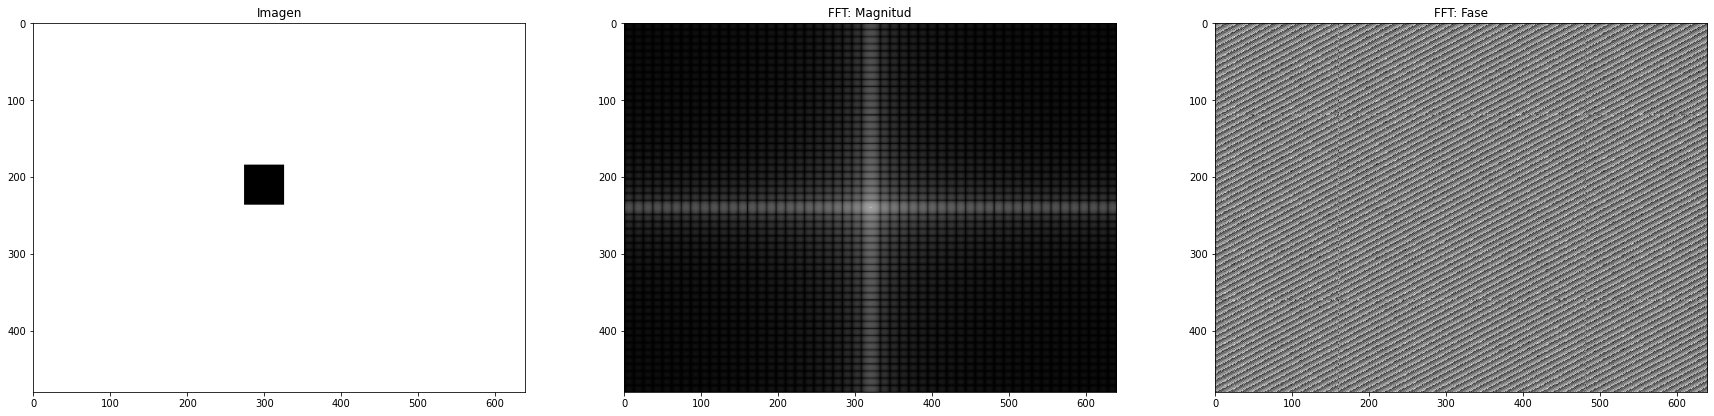

Output()

Output()

In [ ]:
#@title Seleccione la imagen a analizar: { run: "auto" }
square = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/cuadrado.png'
vertical_rectangle = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/rectangulo vertical.png'
horizontal_rectangle = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/rectangulo horizontal.png'
circle = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/circulo.png'
ellipse = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/elipse.png'
rhombus = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/rombo.png'
pattern = '/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/patron.png'

Imagen = 'Cuadrado' #@param ["Cuadrado","Rectangulo_vertical","Rectangulo_horizontal","Circulo","Elipse","Rombo","Patron"]

if Imagen =='Cuadrado':
  image = get_image(square)
if Imagen =='Rectangulo_vertical':
  image = get_image(vertical_rectangle)
if Imagen =='Rectangulo_horizontal':
  image = get_image(horizontal_rectangle)
if Imagen =='Circulo':
  image = get_image(circle)
if Imagen =='Elipse':
  image = get_image(ellipse)
if Imagen =='Rombo':
  image = get_image(rhombus)
if Imagen =='Patron':  image = get_image(pattern) 

#Transformada de Fourier
mag, phase = make_fft(image)
plot_fft(image, mag, phase)

#Botones de guardado
print('\n')
save_buttons(mag,phase,'/content')
print('\n')

path_ifft_save = '/content/imagen_ifft.png'
load_button(phase,path_ifft_save,'LOAD MAGNITUDE')

## 5. Resultados empleando todas las imágenes anteriores

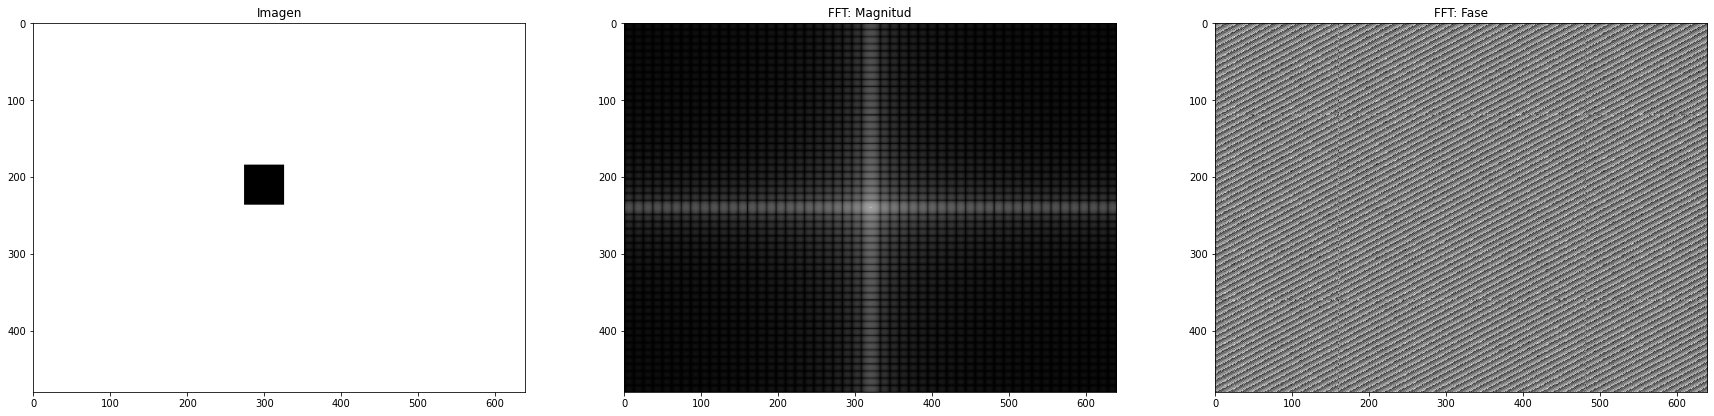

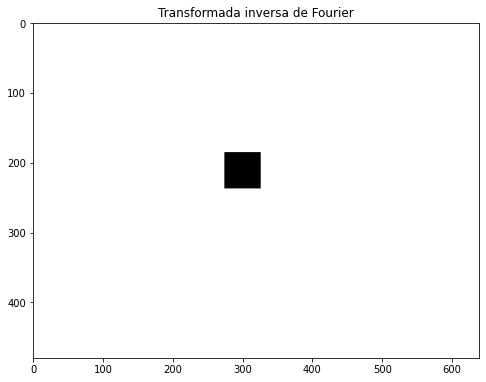

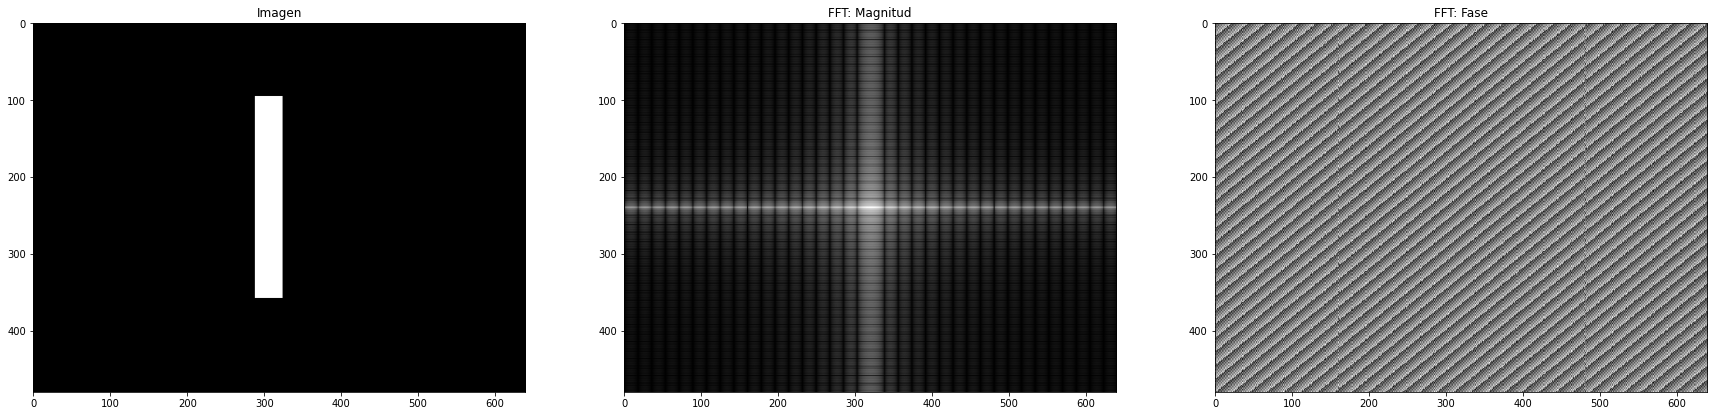

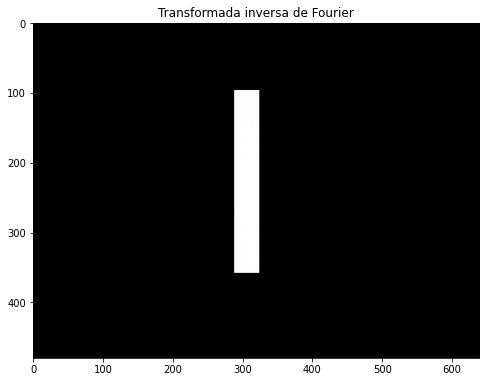

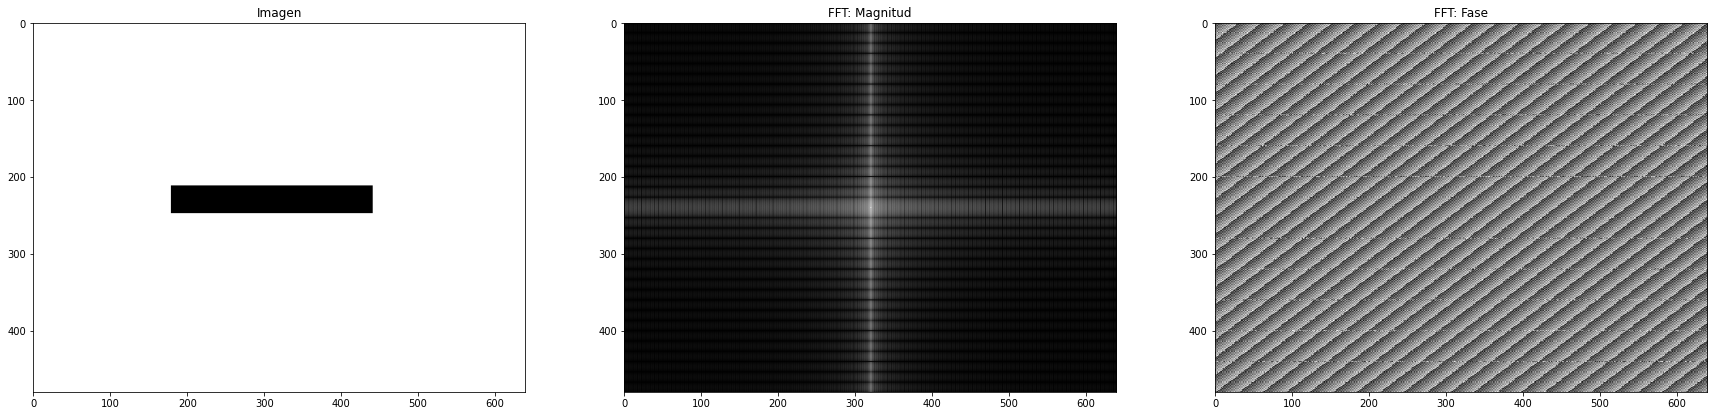

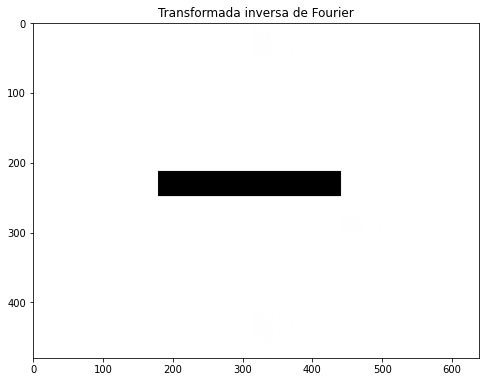

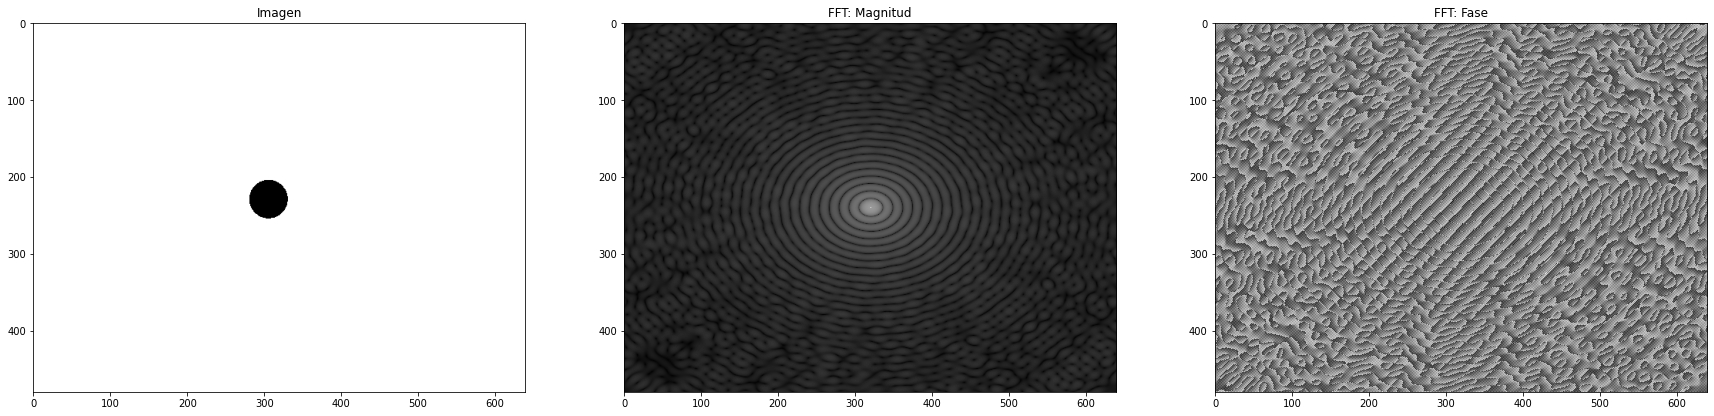

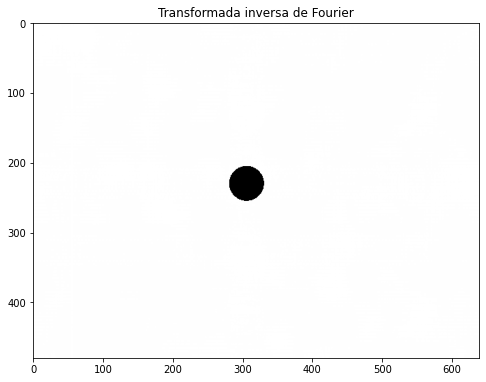

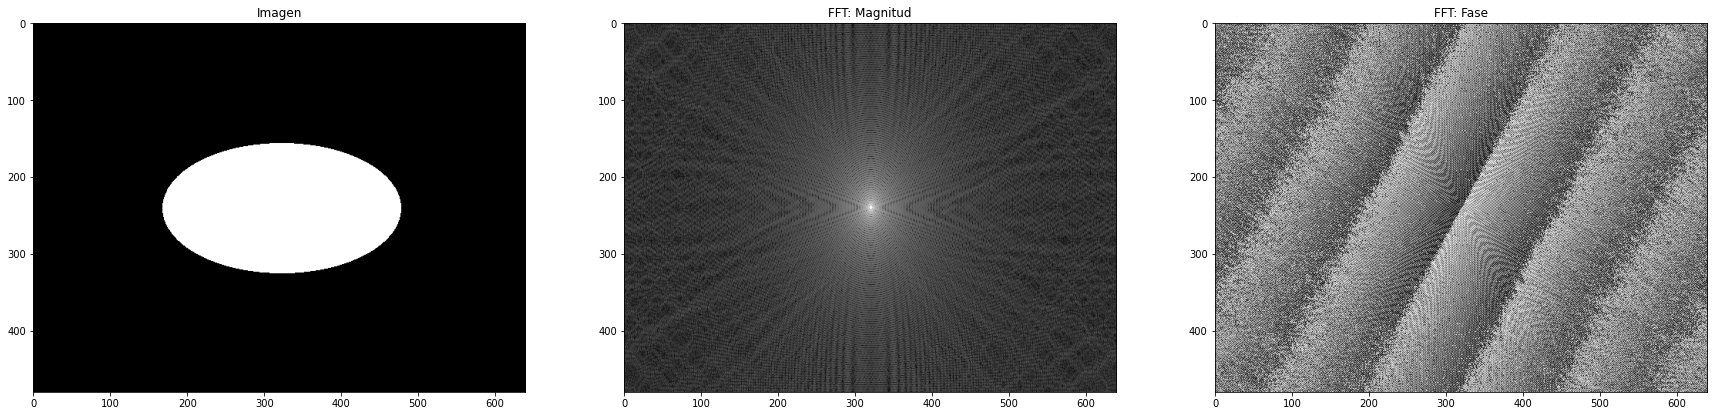

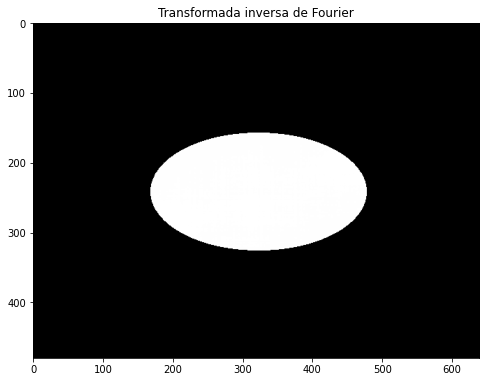

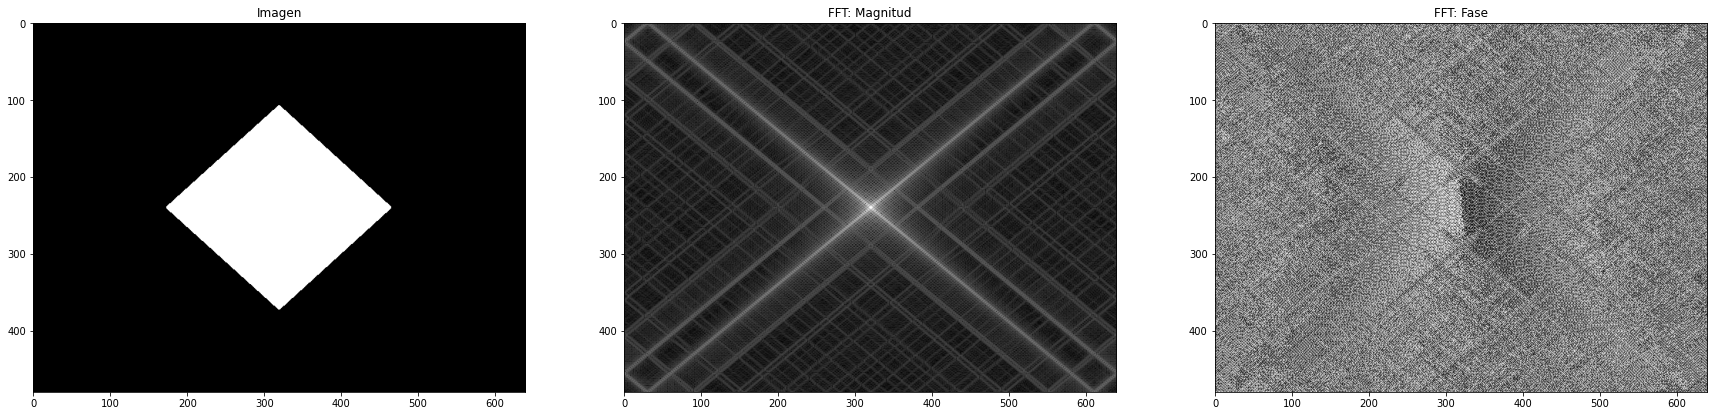

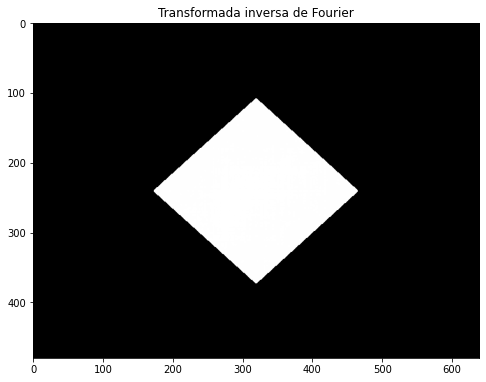

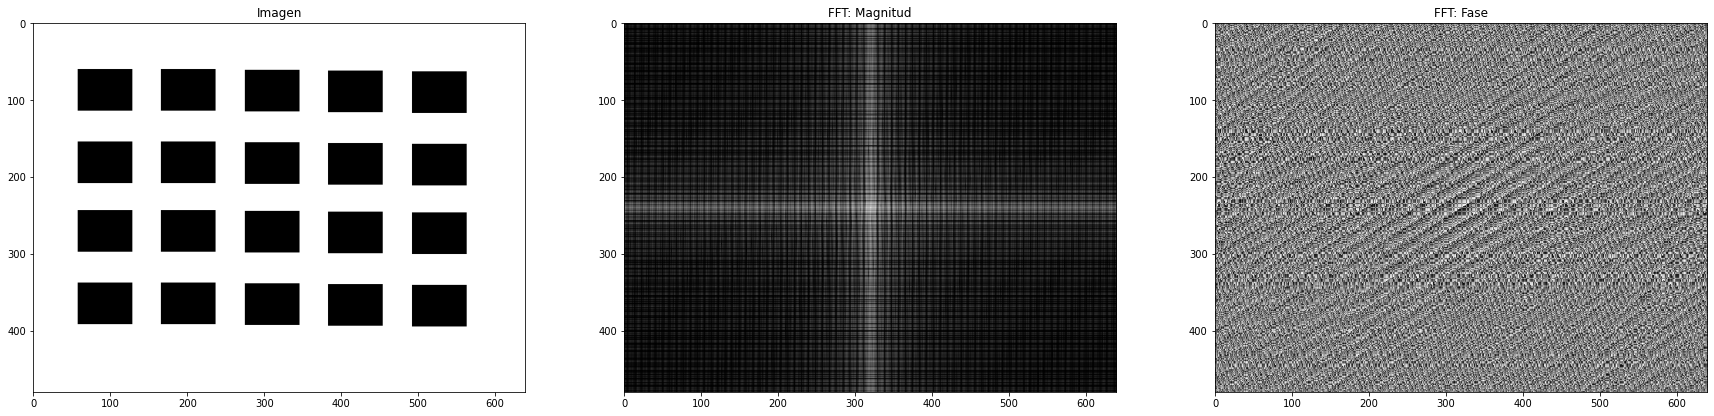

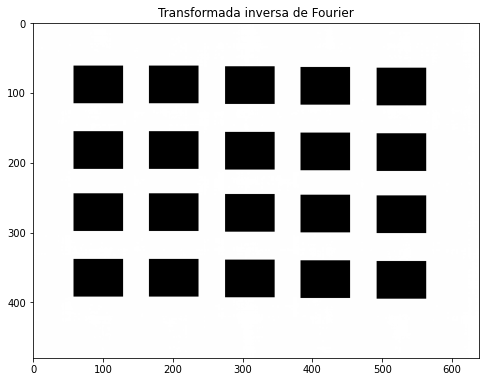

In [ ]:
square = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/cuadrado.png')
vertical_rectangle = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/rectangulo vertical.png')
horizontal_rectangle = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/rectangulo horizontal.png')
circle = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/circulo.png')
ellipse = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/elipse.png')
rhombus = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/rombo.png')
pattern = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/patron.png')

images = np.asarray([square, vertical_rectangle, horizontal_rectangle, circle, ellipse, rhombus, pattern])

for i in range(len(images)):
  #Transformada de Fourier
  mag, phase = make_fft(images[i])
  plot_fft(images[i], mag, phase)

  #Transformada inversa de Fourier
  image_mod = make_ifft(mag, phase)
  plot_ifft(image_mod)

## 6.Modificación del espectro de amplitud con editor gráfico (3 casos de estudio)

El proceso a realizar será el siguiente:

* Se lee la imagen, se aplica la FFT y se guarda su espectro de amplitud en formato .bmp.
* Con ayuda de un editor gráfico se modifica el espectro "cubriendo" zonas del mismo de color negro.
* Se aplica la transformada inversa y se observan los resultados

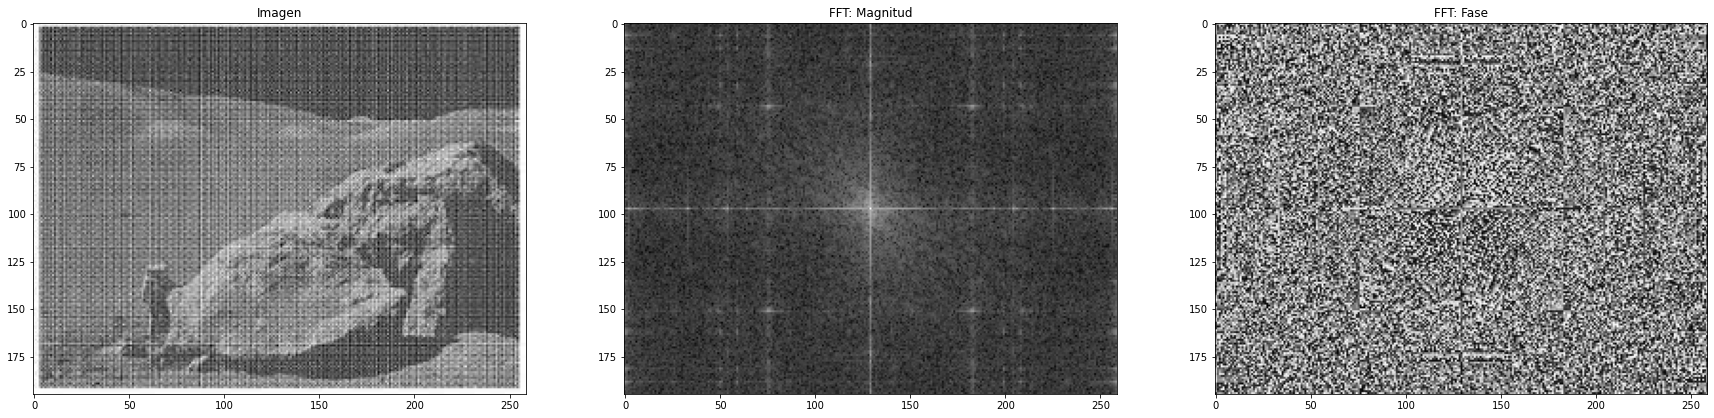

Output()

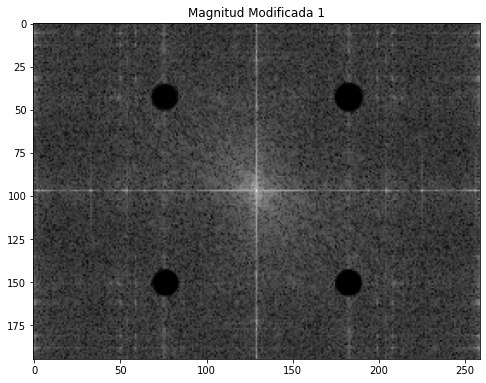

Output()

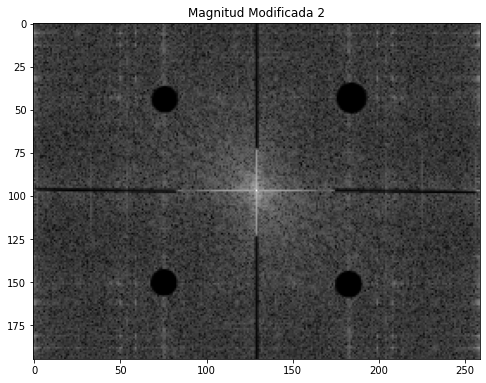

Output()

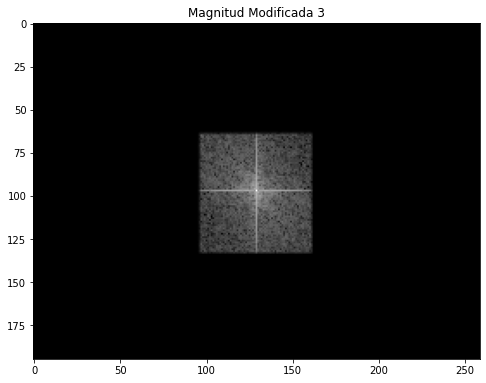

Output()

In [ ]:
image = get_image('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRiRvgbr9AX8jFjde21vgIyaFGfVFbzD6_c58AEx3owhkB8hGDSdOtPET0xIglzMZI6A18&usqp=CAU')

#Transformada de Fourier
mag, phase = make_fft(image)
plot_fft(image, mag, phase)

#Botones de guardado
print('\n')
save_buttons(mag,phase,'/content')
print('\n')

path_ifft_save_1 = '/content/imagen_ifft_1.png'
mag_1 = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/magnitud_mod.bmp')
plot_image(mag_1,'Magnitud Modificada 1')
load_button(phase,path_ifft_save_1,'LOAD MAGNITUDE 1')
print('\n')

path_ifft_save_2 = '/content/imagen_ifft_2.png'
mag_2 = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/magnitud_mod_2.bmp')
plot_image(mag_2,'Magnitud Modificada 2')
load_button(phase,path_ifft_save_2,'LOAD MAGNITUDE 2')
print('\n')

path_ifft_save_3 = '/content/imagen_ifft_3.png'
mag_3 = get_image('/content/drive/MyDrive/Cursos_Posgrado/Procesamiento_Imagenes-UNS/TP5/magnitud_mod_3.bmp')
plot_image(mag_3,'Magnitud Modificada 3')
load_button(phase,path_ifft_save_3,'LOAD MAGNITUDE 3')
print('\n')

## 7. Conclusiones

* Se logró obtener la transformada de Fourier (magnitud y fase) de una imagen y reconstruir la imagen original (habiendo modificado o no su espectro de magnitud).
* En el espectro de magnitud obtenido para la imagen del cuadrado frente a la imagen del rectangulo (vertical u horizontal) es posible observar la característica principal de la transformada, al tener una imagen más comprimida obtenemos un espectro más ancho.
* En cuanto al espectro obtenido para la imagen del rombo, se puede apreciar el efecto de rotación del espectro al compararlo con el resultado obtenido para el cuadrado.
* En cuanto a la modificación del espectro con la imagen de prueba (Parte 5 de este informe) podemos concluir lo siguiente:
  * La primera modificación no alteró significativamente la imagen, ya que posiblemente el ruido presente en la imagen no se encontraba en las frecuencias suprimidas al "pintar" la imagen del espectro de negro.
  * Por otro lado, la segunda modificación si altera la imagen al eliminar aún más frecuencias de la misma. Entre los 3 casos de estudio, este fué el que mejor resultado dió.
  * Por último, en la tercera modificación, se observa como la supresión de frecuencias de la imagen ya es excesiva, llevando consigo características de la imagen y empeorando la misma.